# 1 tutorial: Energy data analysis

This tutorial will learn you how to use data analysis to obtain insight into the context of your energy system. This allows you to get a feeling for the challenges you will have to solve using energy system integration. By first understanding the context, you can better formulate your research questions and hypothesis. Moreover, it forms the fundamental understanding of your energy system that will allow you to explain system dynamics that arise.

## Fetching the data

### Renewable generation

For this tutorial, we will use renewable energy generation curves from [Renewables.ninjas](https://renewables.ninja/). For both the solar and wind energy generation curves, we select a central part of the Netherlands as location. 

```{note}
We use 1 kW as capacity because then we can use it for capacity expansion problems. This gives us a unity curve we can scale up or down for the deployed capacity or use as the `p_max_pu` (maximum power per unit).
```

### Wind energy generation parameters
- Vestas V90 2000 
- 80m hubheight
- 1 kW capacity
- MERRA-2 dataset
- 2019

### Solar energy generation parameters
- Azimuth 180 degrees (south facing)
- Tilt 35 degrees (maximum yearly yield)
- 1 kW capacity
- MERRA-2 dataset
- 2019

### Energy demand

For the energy demand, we will use the [Energy Transition Model](https://energytransitionmodel.com/). We will use one of the scenarios of the Integral Grid Outlook (II3050) for the horizon year 2050: [Decentral Incentives](https://energytransitionmodel.com/saved_scenarios/14552). To download the timeseries from this scenario we follow the following steps:
1. Open the scenario
2. Navigate to `Results & data`
3. Click on `Data export`
4. Select the `Hourly curves for electricity` tab
5. Click the `Electricity load curves` CSV icon

## Load the data

Before we can start loading the data, we will have to import the required modules. This is Pandas for working with the tabular data. And seaborn for the visualisation. Seaborn uses matplotlib as basis for plotting, which we will also import.

In [1]:
# import required modules
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


Now we can start loading the data. Assuming you have made a `/data` folder relative to your Python file containing these files, we can load the data. We use `UPPERCASE` variables in Python to designate constants. It is considered a best practice to use constants to point to file paths. 

In [14]:
ETM_CURVES_FP = "data/merit_order.csv"
WIND_FP = "data/wind.csv"
SOLAR_FP = "data/solar.csv"

etm_demand_supply = pd.read_csv(ETM_CURVES_FP, index_col=0, header=0)
wind = pd.read_csv(WIND_FP, index_col=0, header=0)
solar = pd.read_csv(SOLAR_FP, index_col=0, header=0)

# For wind and solar, we want to drop the 'local_time' column
wind.drop(columns=['local_time'], inplace=True)
solar.drop(columns=['local_time'], inplace=True)

# Convert the index to datetime
solar.index = pd.to_datetime(solar.index)
wind.index = pd.to_datetime(wind.index)

## Visualise the generation data
With the files loaded, we can visualise the energy generation data. We will first set the seaborn theming and initiate the plot.

<Axes: title={'center': 'Solar energy generation (-)'}, xlabel='time'>

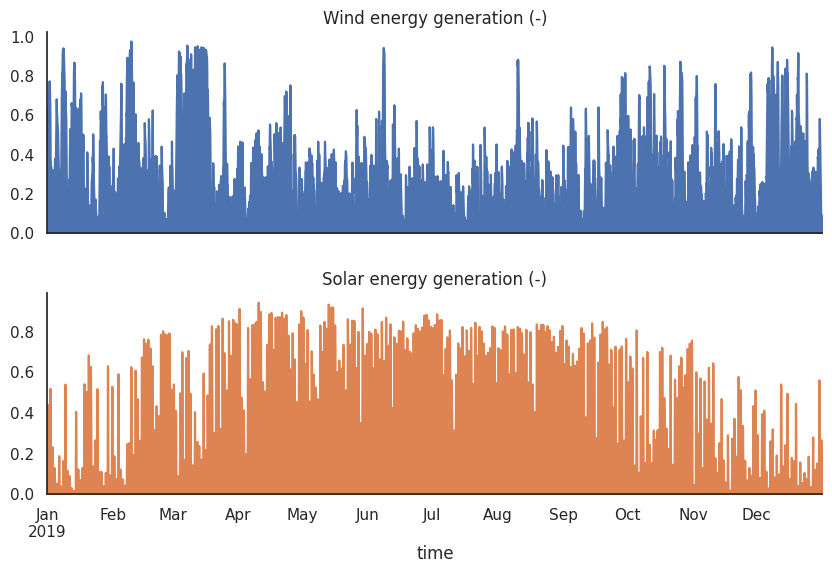

In [106]:
# Set the seaborn style
sns.set_theme("notebook", style="white")
plt.rc("axes.spines", top=False, right=False)
cm = sns.color_palette()

# Set up the matplotlib figure
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
plt.subplots_adjust(hspace=0.3)


wind.plot(
    ax=ax[0],
    kind="area",
    title="Wind energy generation (-)",
    legend=False,
    color=cm[0],
)
solar.plot(
    ax=ax[1],
    kind="area",
    title="Solar energy generation (-)",
    legend=False,
    color=cm[1],
)

### Analyse the plot
From this figure we can see that the wind and solar energy generation are highly variable. This is due to the fact that the wind and solar energy generation are dependent on the weather conditions.This variability in the wind and solar energy generation can make it difficult to integrate these energy sources into the electricity grid. This is why it is important to have a mix of different energy sources, interconnection and storage in the electricity grid, so that the variability of the wind and solar energy generation can be balanced out by other energy system components.


```{note}
#### Capacity Factor
The Capacity Factor is a measure of how often an energy source operates at its maximum output over a specific period, typically one year. It is defined as the ratio of the actual energy produced to the maximum possible energy that could have been produced if the system operated at its rated capacity continuously over the same period.

\begin{equation*}
 \text{Capacity Factor} = \frac{E_{\text{actual}}}{P_{\text{rated}} \times T} 
\end{equation*}
```

```{note}
#### Full load hours (FLH) 
Full load hours are a good indicator of the variability of a renewable energy source. The Full Load Hours (FLH) represent the equivalent number of hours that a renewable energy system would need to operate at its rated capacity to generate the same amount of energy it actually produced over a specific period (typically one year).

\begin{equation*}
\text{FLH} = \frac{E_{\text{annual}}}{P_{\text{rated}}} 
\end{equation*}
In contrast, dispatchable energy sources, such as coal, natural gas, and nuclear plants, could theoretically run continuously for the whole year, giving them a potential FLH of 8,760 hours, minus any downtime for maintenance or other interruptions. Typically, market conditions prevent these sources from getting near to these FLHs from occurring.
```

### Statistical indicators of energy generation
Lets determine the FLH per technology and the monthly capacity factor using the equations above. 


In [9]:
# We have a unity scaled curve, we do not need to normalize the data by the rated power (since it is 1)
solar_flh = solar.sum().sum() 
wind_flh = wind.sum().sum()

print(f"Wind FLH: {wind_flh:.2f} hours")
print(f"Solar FLH: {solar_flh:.2f} hours")

Wind FLH: 2554.05 hours
Solar FLH: 1362.12 hours


From this, we can conclude that the wind capacity factor is quite low (modern turbines get up to 3600 FLH on land). And the solar FLH is on the quite high side (typically around 1000 FLH in the Netherlands). Since we typically oversize solar power plants on the DC to AC ratio (more solar panels than inverters), we are safe to use this value. 

It also becomes clear that wind has double the FLH of solar. Let us now determine the monthly capacity factor and plot it. 

<Axes: title={'center': 'Monthly capacity factor (-)'}, xlabel='time'>

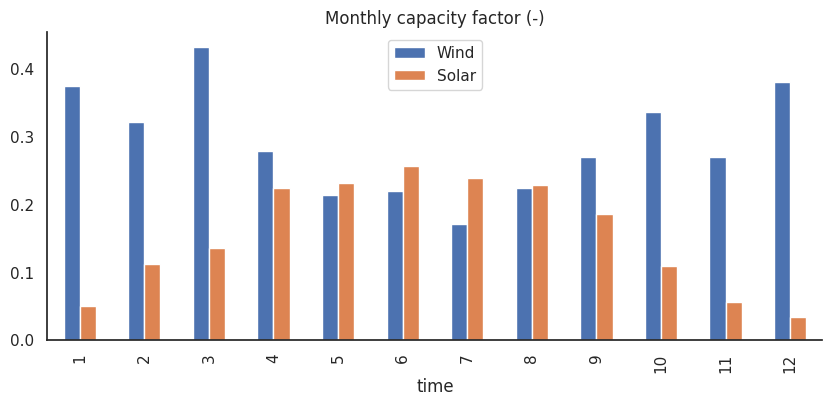

In [12]:
# since we have a unity scaled curve, we do not need to normalize the data (dividing by the rated power and time)
solar_cf = solar.groupby(solar.index.month).mean()
wind_cf = wind.groupby(wind.index.month).mean()

# Set up the matplotlib figure
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

# Combine the data into a single DataFrame for plotting
combined_cf = pd.DataFrame({
    'Wind': wind_cf['electricity'],
    'Solar': solar_cf['electricity']
})

combined_cf.plot(
    ax=ax,
    kind="bar",
    title="Monthly capacity factor (-)",
    legend=True,
    position=0.5
)



This figure illustrates the complementary seasonal patterns of wind and solar energy through their monthly capacity factors. Wind performs best in winter months, while solar shows peak performance in summer months. 

These patterns have important implications for energy system design. The complementary nature of wind and solar suggests benefits in combining both technologies, though the relatively low capacity factors highlight why installed capacity must exceed average demand. The seasonal variations also emphasize the need for storage solutions or backup power sources to maintain reliable supply throughout the year.

### Energy demand analysis
Let us now analyse the energy demand. We will investigate it by determinging the:
- The distribution of demand across the categories based on **energy** 
- The distribution of demand across the categories based on **peak power**
- The monthly normalized demand curve to get a feeling for the seasonal variation

Before that, we'll clean up our data and plot the energy demand.

In [60]:
# parse the index to datetime
etm_demand_supply.index = pd.to_datetime(etm_demand_supply.index)

## filter on demand categories
# 1. select all colums that are demand (.input)
# 2. select all columns that are electricity
# 3. and exclude interconnectors and flexibility
demand = etm_demand_supply[
    [
        col
        for col in etm_demand_supply.columns
        if (
            (".input" in col and "electricity" in col)
            and all(
                [
                    not excluder in col
                    for excluder in [
                        "interconnector",
                        "flexibility",
                    ]
                ]
            )
        )
    ]
]
# clean the column names
demand.columns = (
    demand.columns.str.replace(".input", "")
    .str.replace("_", " ")
    .str.replace("electricity (MW)", "")
    .str.title()
)

# calculate the summed, total, max and mean demand
demand_total = demand.sum(axis=1).sum()  # number
demand_summed = demand.sum(axis=1)  # series
demand_mean = demand_summed.mean()  # number
demand_max = demand_summed.max()  # number



#### Plot the energy demand

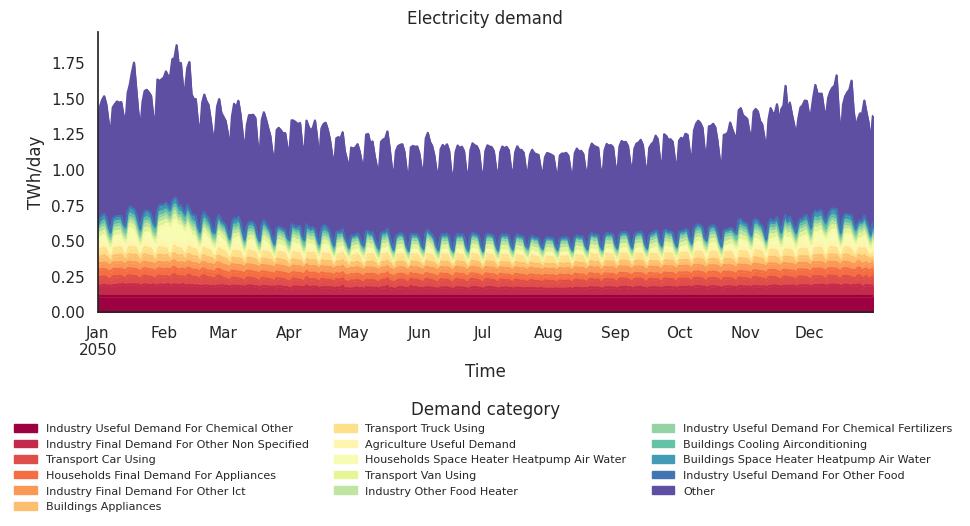

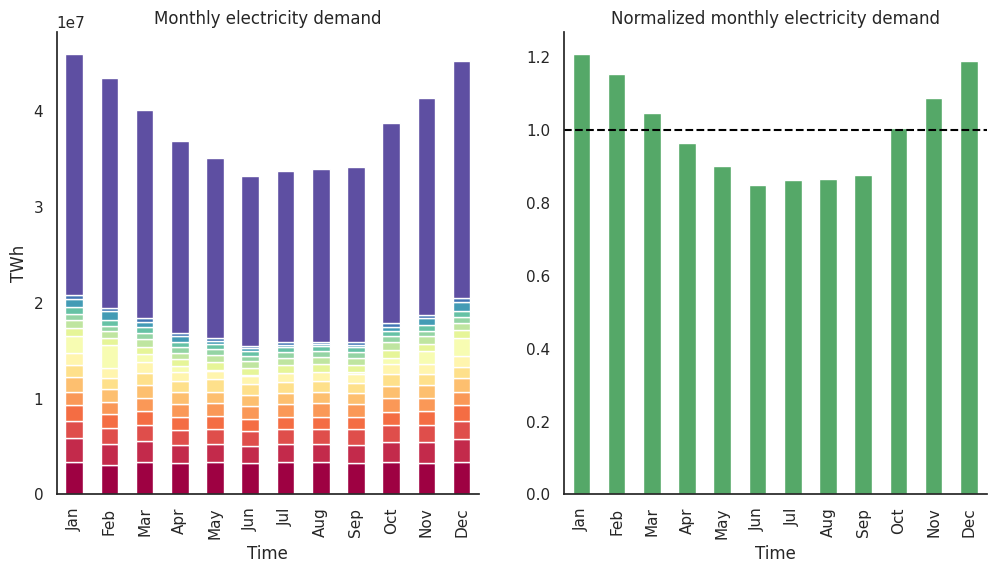

In [104]:
# Set up the matplotlib figure
fig, ax = plt.subplots(2, 1, figsize=(10, 5), gridspec_kw={"height_ratios": [8, 2]})
#  remove the figure of the second axes
ax[1].remove()


# determine the top demand categories and sum the rest to 'other'
top_demand = demand.sum(axis=0).nlargest(15)
other_demand = demand.columns.difference(top_demand)

plottable_demand = demand.loc[:, top_demand.index]
plottable_demand.loc[:, "Other"] = demand.loc[:, other_demand].sum(axis=1)

# resample to daily data
plottable_demand_daily = plottable_demand.resample("D").sum().div(1e6)

# plot the demand categories
plottable_demand_daily.plot(
    ax=ax[0], kind="area", title="Electricity demand", legend=True, colormap="Spectral"
)
ax[0].set_ylabel("TWh/day")

ax[0].legend(
    bbox_to_anchor=(0.5, -0.3),
    loc=9,
    borderaxespad=0.0,
    frameon=False,
    title="Demand category",
    ncol=3,
    fontsize=8,
)

# Monthly normalized electricity demand

monthly_demand = demand_summed.resample("ME").sum().div(1e6)
mean_monthly_demand = monthly_demand.mean()
mne_demand = monthly_demand / mean_monthly_demand

# overwrite the monthly demand with the plottable demand
monthly_demand = plottable_demand.resample("ME").sum()

# Set up the matplotlib figure
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# make the index a pretty string
monthly_demand.index = monthly_demand.index.strftime("%b")
mne_demand.index = mne_demand.index.strftime("%b")

monthly_demand.plot(
    ax=ax[0],
    kind="bar",
    stacked=True,
    title="Monthly electricity demand",
    legend=False,
    colormap="Spectral",
)

ax[0].set_ylabel("TWh")
# add a horizontal line for the mean

mne_demand.plot(
    ax=ax[1],
    kind="bar",
    title="Normalized monthly electricity demand",
    legend=False,
    color=cm[2],
)

ax[1].set_ylabel("")
# add a horizontal line for the mean
ax[1].axhline(1, color="black", linestyle="--")

### Analysis of electricity demand curves
From this figure we can observe a lot of weekly cyclic behaviour - showing higher demand during weekdays and noticeable drops during weekends - because of industrial demand. Furthermore, the energy demand is higher in the winter than during the summer period. Also, we can see a longer period with high demand from space heating in the first three weeks of February. We will have to keep this in mind when we do system integration, as we now have some sort of idea what might form a pinch point for this energy system.

The seasonal pattern aligns with what we saw earlier in the renewable generation capacity factors, which will be critical for matching supply and demand.

<Axes: title={'center': 'Peak demand and energy share (%)'}>

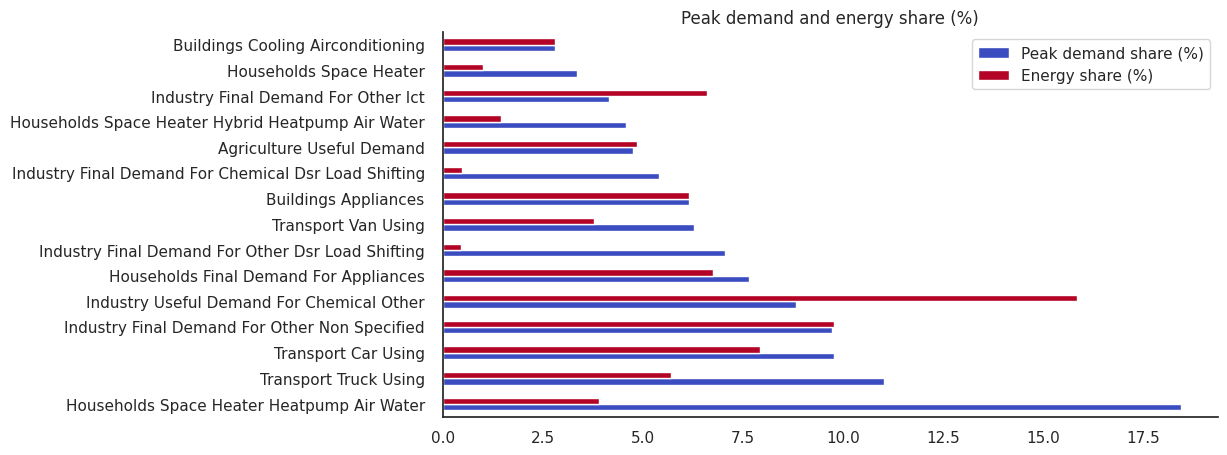

In [ ]:


energy_share = demand.sum(axis=0) / demand_total  # left hand is a series, right hand is a number

peak_demand_share = demand.max() / demand_max # left hand is a series, right hand is a number
peak_demand_share.sort_values(ascending=False)


fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plt.subplots_adjust(hspace=0.4)
subset_peak_demand = peak_demand_share.nlargest(15).mul(100)
corresponding_energy_share = energy_share.loc[subset_peak_demand.index].mul(100)

combined_df = pd.DataFrame({
    "Peak demand share (%)": subset_peak_demand,
    "Energy share (%)": corresponding_energy_share
})

combined_df.plot(
    ax=ax,
    kind="barh",
    title="Peak demand and energy share",
    legend=True,
    colormap="coolwarm"
)


### Analysis of peak energy and energy share graph
The most notable insight is the large mismatch for heat pumps - while they only account for about 3% of total energy consumption, they are responsible for nearly 17% of peak demand. This makes them a critical consideration for system design.
In contrast, industrial and transport sectors show more balanced patterns, with their peak demand shares more closely matching their energy shares (around 7-10%). This indicates more steady consumption patterns throughout the year. These insights help identify where we need to focus on peak management strategies like storage or demand response to ensure system reliability.

## Conclusion
The analysis of renewable generation and demand patterns reveals several crucial insights for energy system integration. The complementary seasonal patterns of wind and solar generation (wind peaking in winter, solar in summer) provide opportunities for balancing, though their relatively low capacity factors necessitate significant oversizing of installed capacity.

Demand analysis shows strong seasonal and weekly patterns, with winter peaks driven largely by heating demand. A critical challenge emerges from heat pumps, which despite their modest share of total energy consumption (3%), contribute significantly to peak demand (17%). This mismatch, combined with the variability of renewable generation, highlights the importance of system flexibility through measures such as storage, demand response, and sector coupling. Understanding these patterns and relationships is fundamental for designing reliable and efficient integrated energy systems that can manage both seasonal variations and peak demand events.